# GPT模型
- GPT使用的是Transformer的解码器
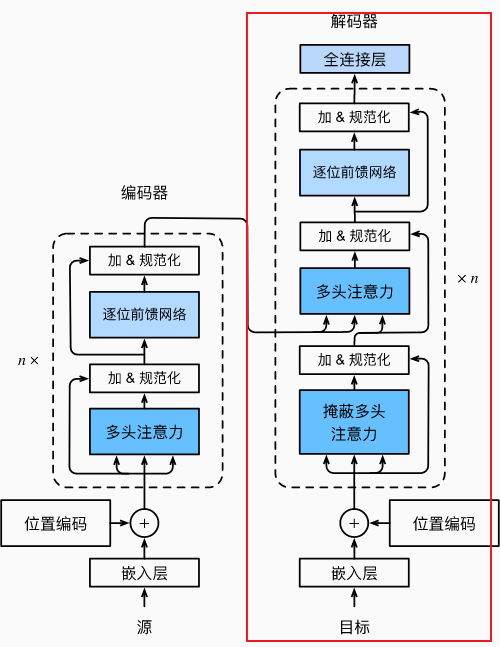

## 我需要知道的事情？
- 输入从哪里进来？
- 与解码器相连的那个输入是直接不要了吗？
- 输出是什么样子的？

# 1、先定义一些搭建注意力模型需要的函数
- ScaledDotProductionAttention：
    - 用于计算缩放点积注意力， 在MultiHeadAttention中被调用
- 多头自注意力 MultiHeadAttention：
    - 多头注意力的实现， Transformer的核心
- 前馈网络(MLP)和层归一化FeedForward Networks：
    - 对应Feed Forward和 Add & Norm层归一化
- get_attn_pad_mask：
    - 这是一个计算mask的函数，它的返回是一个布尔矩阵，为True的位置是需要被mask掉的，False的位置是不需要动的，这个函数是理解Transformer代码中非常重要的一环，因为我们输入模型的句子有长有短，我们用占位符P统一补足成了最长的那个句子的长度，而这些占位符是没有意义的，不能让他们吸收到query的注意力，因此我们要把这些位置设为True
-  get_attn_subsequence_mask掩蔽自注意力：
    - 对应Transformer模型架构中Decoder的第一个掩蔽注意力，防止模型看到未来时刻的输入

### 1.1 ScaledDotProductAttention
- 用于计算缩放点积注意力， 在MultiHeadAttention中被调用

In [5]:
class ScaledDotProductionAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductionAttention, self).__init__()
        
    def forward(self, Q, K, V, attn_mask):
        # Q: [batch_size, n_heads, len_q, d_k]
        # K: [batch_size, n_heads, len_k, d_k]
        # V: [batch_size, n_heads, len_v(=len_k), d_v]
        # 总共使用两处自注意力， 一处时自注意力，一处时掩蔽自注意力
        # attn_mask: [batch_size, n_heads, seq_len, seq_len]
        
        # 1、计算注意力分数QK^T/sqrt(d_k),
        # np.sqrt(d_k) 是一个平方根函数，它可以将一个非负实数的平方根提取出来。除以 sqrt(d_k) 来降低结果的数值大小，使其落入一个小范围。
        # 为什么要除一个根号d_k？这是因为点积的数量级增长很大，因此将 softmax 函数推向了梯度极小的区域
        # 这样做的目的是使softmax函数能够更加稳定地运行，从而提高模型的性能和鲁棒性。
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) 
        
        # 2、进行mask和softmax
        # mask为True的地方会被设置为-1e9，相当于不考虑
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores) # attn:[batch_szie, n_heads, len_q, len_k]
        # 3、乘V得到最终的加权和
        context = torch.matmul(attn, V) # context:[batch_size, n_heads, len_q, d_v]
        # 返回的context: [batch_size, n_heads, len_q, d_v]本质上还是batch_size个句子，
        # 只不过每个句子中词向量维度512被分成了8个部分，分别由8个头各自看一部分，每个头算的是整个句子(一列)的512/8=64个维度，最后按列拼接起来
        
        return context,attn# [batch_size, n_heads, len_q, d_v]

### 1.2 多头自注意力 MultiHeadAttention
- 多头注意力的实现， Transformer的核心
- 原来一个头对应512个特征，现在分为8个头，每个头处理64个特征
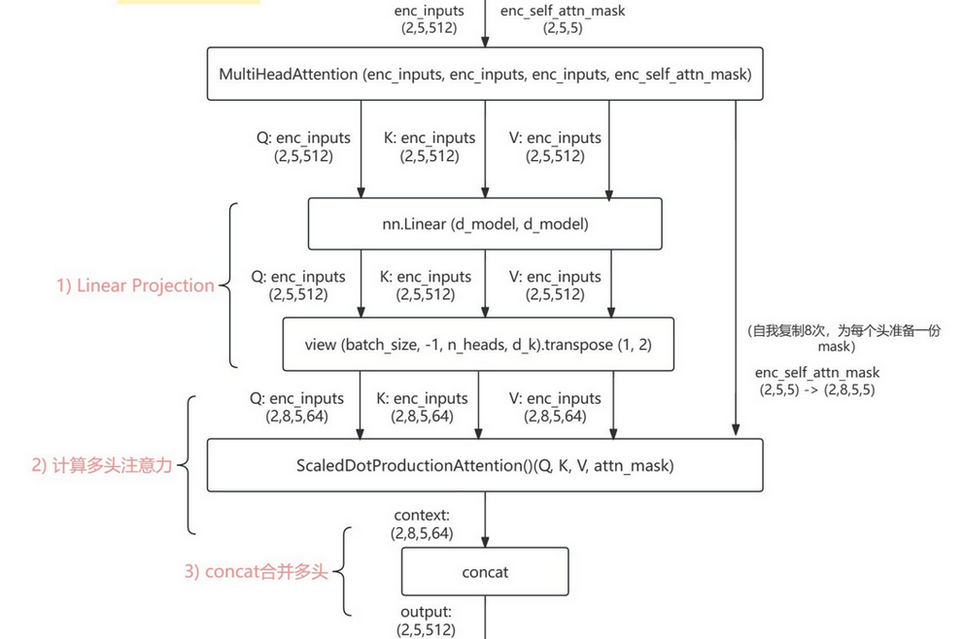

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.concat = nn.Linear(d_model, d_model)
        
    def forward(self, input_Q, input_K, input_V, attn_mask):
        # input_Q:[batch_size, len_q, d_model] len_q是作为query的句子的长度，比如enc_inputs(2, 5, 512), 句子长度5就是len_q
        # input_K:[batch_size, len_k, d_model]
        # input_V:[batch_size, len_v(=len_k), d_model]
        
        residual, batch_size = input_Q, input_Q.size(0)
        
        # 1、线性投影：通过原始输入，映射出QKV，然后调整形状，准备多个头，每个头对应64个特征
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2) # Q:[batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2) # K:[batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1, 2) # V:[batch_size, n_heads, len_v, d_k]
        
        # 2、计算注意力
        # 先自我复制n_heads次，为每个头准备一份mask
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask:[batch_size, n_heads, seq_len, seq_len]
        context, attn = ScaledDotProductionAttention()(Q, K, V, attn_mask) # context:[batch_size, n_heads, len_q, d_v]
        
        # 3、concat部分
        context = torch.cat([context[:,i,:,:] for i in range(context.size(1))], dim=-1)
        output = self.concat(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).cuda()(output + residual), attn # output:[batch_size, len_q, d_mdoel] 这一步加了残差

### 1.3 前馈网络(MLP)和层归一化FeedForward Networks
- 对应Feed Forward和 Add & Norm层归一化

In [20]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        # 前馈神经网络也就是MLP多层感知机
        self.fc = nn.Sequential(
           nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
    
    def forward(self, inputs):
        """inputs:[batch_size, seq_len, d_model]"""
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # 先残差连接，然后层归一化从右往左计算

### 1.4 Pad Mask
- 首先我们要清楚，这是一个计算mask的函数，它的返回是一个布尔矩阵，为True的位置是需要被mask掉的，False的位置是不需要动的
- 其次这个函数是理解Transformer代码中非常重要的一环，因为我们输入模型的句子有长有短，我们用占位符P统一补足成了最长的那个句子的长度，而这些占位符是没有意义的，不能让他们吸收到query的注意力，因此我们要把这些位置设为True
- 这个计算出的mask在何时被使用呢？
    - 在query和key的转置相乘得出（len_q,len_k）这个注意力分数矩阵以后，将使用本函数得到的mask来掩盖相乘结果矩阵
    - 原来的相乘结果矩阵（len_q,len_k）中第 i 行第 j 列的意义是“作为q的序列中第i个词对作为k的序列中第j个词的注意力分数”，而第 i 整行就是q中这个词对k中所有词的注意力，第 j 整列就是q中所有词对k中第j个词的注意力分数，作为padding，q中的所有词都不应该注意它，因此对应列均需设为True
- 为什么只有k的padding位被mask了，q的padding位为什么没被mask？（即此函数的返回矩阵为什么只有最后几列是True，最后几行不应该也是True么）
    - 按理来说是这样的，作为padding不该被别人注意，同时它也不该注意别人，计算出的padding对其他词的注意力也是无意义的，我们这里其实是偷了个懒，但这是因为：q中的padding对k中的词的注意力我们是不会用到的，因为我们不会用一个padding字符去预测下一个词，并且它的向量表示不管怎么更新都不会影响到别的q中别的词的计算，所以我们就放任自流了。但k中的padding不一样，如果不管它将无意义的吸收掉大量q中词汇的注意力，使得模型的学习出现偏差。

In [8]:
# 为enc_input和 dec_input做一个mask，把占位符P的token（也就是0）mask掉
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    
    # seq_k.data.eq(0)返回一个相同大小的布尔张量，seq_k元素等于0的位置为True， 否则为False
    # .unsqueeze(1)扩充维度
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    
    # 要为每一个q提供一份k， 所以把第二维度扩展了q次
    # expand并非真正加倍内存，知识重复了引用，对任意引用的修改都会修改原始值
    # 不修改这个mask，用来节省内存
    
    return pad_attn_mask.expand(batch_size, len_q, len_k) # return :[batch_size, len_q, len_k]

### 1.5 Subsequence Mask
- 掩蔽自注意力
- 对应Transformer模型架构中Decoder的第一个掩蔽注意力，防止模型看到未来时刻的输入
- 在推理的时候，是看不到还未推理的单词的所以在训练时也需要将未来时刻的词元掩蔽掉
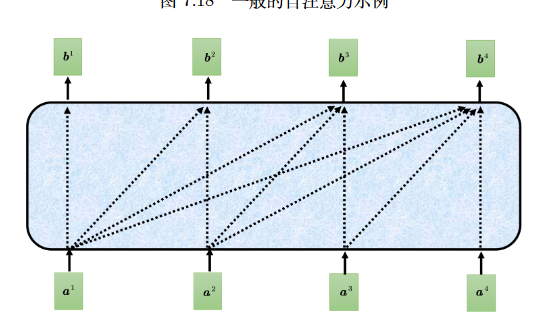

In [9]:
# 用于获取对后续位置的掩码，防止在预测过程中看到未来时刻的输入
def get_attn_subsequence_mask(seq):
    
    # seq:[batch_size, tgt_len]
    # batch_size个tgt_len * tgt_len的mask矩阵
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    
    # np.triu是生成一个upper traingular matrix上三角矩阵，K是相对主对角线的偏移量
    # k=1是之不包含住对角线
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)
    subsequence_mask = torch.from_numpy(subsequence_mask).byte() # 因为只有0，1所以使用byte节省内存
    
    return subsequence_mask # [batch_size, tgt_len, tgt_len]

# 没有理解代码意思！

# 2.搭建一层Transformer的解码器层
- GPT只用到解码器

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, dec_self_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)

        dec_outputs = self.pos_ffn(dec_outputs)  # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn

# 3.将解码器层叠在一起
- 加上了位置编码

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_pos,d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        '''
        seq_len = dec_inputs.size(1)
        pos = torch.arange(seq_len, dtype=torch.long,device=device)
        pos = pos.unsqueeze(0).expand_as(dec_inputs)  # [seq_len] -> [batch_size, seq_len]

        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(pos) # [batch_size, tgt_len, d_model]

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs) # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs)# [batch_size, tgt_len, tgt_len]
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0) # [batch_size, tgt_len, tgt_len]



        dec_self_attns = []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn = layer(dec_outputs, dec_self_attn_mask)
            dec_self_attns.append(dec_self_attn)

        return dec_outputs, dec_self_attns

# 4.组合最终的GPT模型

In [12]:
class GPT(nn.Module):
    
    def __init__(self):
        super(GPT, self).__init__()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, vocab_size)
    
    def forward(self, dec_inputs):
        # dec_inputs:[batch_size, tgt_len]
        
        # dec_outputs:[batch_size, tgt_len, d_model], 
        # dec_self_attns:[n_layers, batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attns = self.decoder(dec_inputs)
        
        # dec_logits:[batch_size, tgt_len, tgt_vocab_size]
        dec_logits = self.projection(dec_outputs)
        return dec_logits.view(-1, dec_logits.size(-1)), dec_self.attns
    
    def greedy_decoder(self, dec_inputs):
        
        terminal = False
        start_dec_len = len(dec_input[0])
        
        # 一直预测下一个单词，直到预测到"<sep>"结束，
        # 如果一直不到，则根据长度退出循环并在结尾加上<sep>"
        while not terminal:
            if len(dec_input[0]) - start_dec_len > 100:
                net_symbol = word2id['<sep>']
                dec_input = torch.cat(
                    [dec_input.detach(), torch.tensor([[next_symbol]], dtype=dec_input.dtype, device=device)], -1)
                break
            dec_outputs, _ = self.decoder(dec_input)
            projected = self.projection(dec_outputs)
            prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
            next_word = prob.data[-1]
            next_symbol = next_word
            if next_symbol == word2id["<sep>"]:
                terminal = True
                
            dec_input = torch.cat(
                [dec_input.detach(), torch.tensor([[next_symbol]], dtype=dec_input.dtype, device=device)], -1
            )
            
            return dec_input
    
    def answer(self, sentence):
        # 把原始锯子的\T替换成"<sep>"
        dec_input = [word2id.get(word, 1) if word != '\t' else word2id['<sep>'] for word in sentence]
        dec_input = torch.tensor(dec_input, dtype=torch.long, device=device).unsqueeze(0)
        
        output = self.greedy_decoder(dec_input).squeeze(0)
        out = [id2word[int(id)] for id in output]
        
        # 统计"<sep>"字符在结果中的索引
        sep_indexs = []
        for i in range(len(out)):
            if out[i] == "<sep>":
                sep_indexs.append(i)
        
        # 取最后两个sep中间的内容作为回答
        answer = out[sep_indexs[-2]+1:-1]
        
        answer = "".join(answer)
        return answer

# 5.实例化模型并检查

In [2]:
import json
import torch
import torch.utils.data as Data
from torch import nn, optim
import numpy as np
import time
from tqdm import tqdm

In [13]:
device = torch.device("cpu")
# dict_datas = json.load(open('dict_datas.json', 'r'))
# word2id, id2word = dict_datas['word2id'], dict_datas['id2word']
vocab_size = 1000
max_pos = 1800
d_model = 512  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention
CLIP = 1


In [23]:
gpt = GPT()
gpt

GPT(
  (decoder): Decoder(
    (tgt_emb): Embedding(1000, 512)
    (pos_emb): Embedding(1800, 512)
    (layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (dec_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (concat): Linear(in_features=512, out_features=512, bias=True)
        )
        (dec_enc_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (concat): Linear(in_features=512, out_features=512, bias=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (fc): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): ReLU()
    